In [1]:
import pandas as pd

df = pd.read_csv('my_data.csv')
df.drop(['entry_id', 'pos1', 'pos2'], axis = 1, inplace = True)

In [2]:
len(df)

463068

In [3]:
x = df['bread1'].values.tolist()
y = df['bread2'].values.tolist()
corpus = x + y

In [4]:
len(corpus)

926136

In [5]:
import re
import nltk
nltk.download('stopwords')
sw_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tanmesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# removing all the special characters
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist

def preprocess(x):
    s = ''
    x = re.sub('\W+', ' ', x)
    for data in x:
        if data not in sw_list:
            s += " "+data
    s = s[1:]
    s = '  '.join(unique_list(s.split()))
    return x

new_corpus = []
for data in corpus :
    data = str(data).lower()
    new_corpus.append(preprocess(data))

corpus = new_corpus

In [7]:
corpus[0]

'clothing accessories men winterwear jackets '

In [8]:
# copy data in "latest_file.csv"
with open('latest_file.csv', 'w') as f:
    i = 0
    for data in corpus :
        if i < len(corpus)/10000 :
            f.write("%s\n" % data)
            i += 1

In [9]:
df = pd.read_csv('latest_file.csv', names = ['breads', 'label'])

In [10]:
df.head()

,breads,label
0,clothing accessories men winterwear jackets,NaN
1,clothing accessories men winterwear sweatshirt...,NaN
2,shoes handbags shoes men s shoes men running s...,NaN
3,home entertainment audio video tv headphones e...,NaN
4,home kitchen small kitchen appliances mixer gr...,NaN


In [11]:
token_corpus = []
for data in corpus :
    token_corpus.append(nltk.word_tokenize(data))

In [12]:
token_corpus[0]

['clothing', 'accessories', 'men', 'winterwear', 'jackets']

In [13]:
import gensim 
from gensim import models, similarities, corpora
import gensim.models.word2vec as w2v
import multiprocessing

num_features = 300
min_word_count = 1
num_workers = multiprocessing.cpu_count()
context_size = 3
downsampling = 1e-3
seed = 1

model = w2v.Word2Vec( 
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling)


In [14]:
model.build_vocab(token_corpus)

In [15]:
print("Word2Vec vocabulary length:", len(model.wv.vocab))

Word2Vec vocabulary length: 19930


In [16]:
model.train(token_corpus, len(model.wv.vocab), epochs = 1)

(4695964, 7500546)

In [17]:
model.save("word2vec.model")

In [18]:
model = w2v.Word2Vec.load("word2vec.model")

In [19]:
import sklearn
from sklearn import manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [20]:
all_word_vectors_matrix = model.wv.syn0

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [21]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [22]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [23]:
points.head(10)

,word,x,y
0,clothing,-65.959908,21.523775
1,accessories,-66.476677,-0.556600
2,men,-66.959801,19.644306
3,winterwear,-45.207489,12.135808
4,jackets,-65.918602,21.292482
5,sweatshirts,-65.914673,21.185463
6,hoodies,-45.424820,13.067222
7,shoes,-67.039124,19.522680
8,handbags,-66.885658,19.494860
9,s,-66.981606,19.593664


In [24]:
import seaborn as sns
sns.set_context("poster")

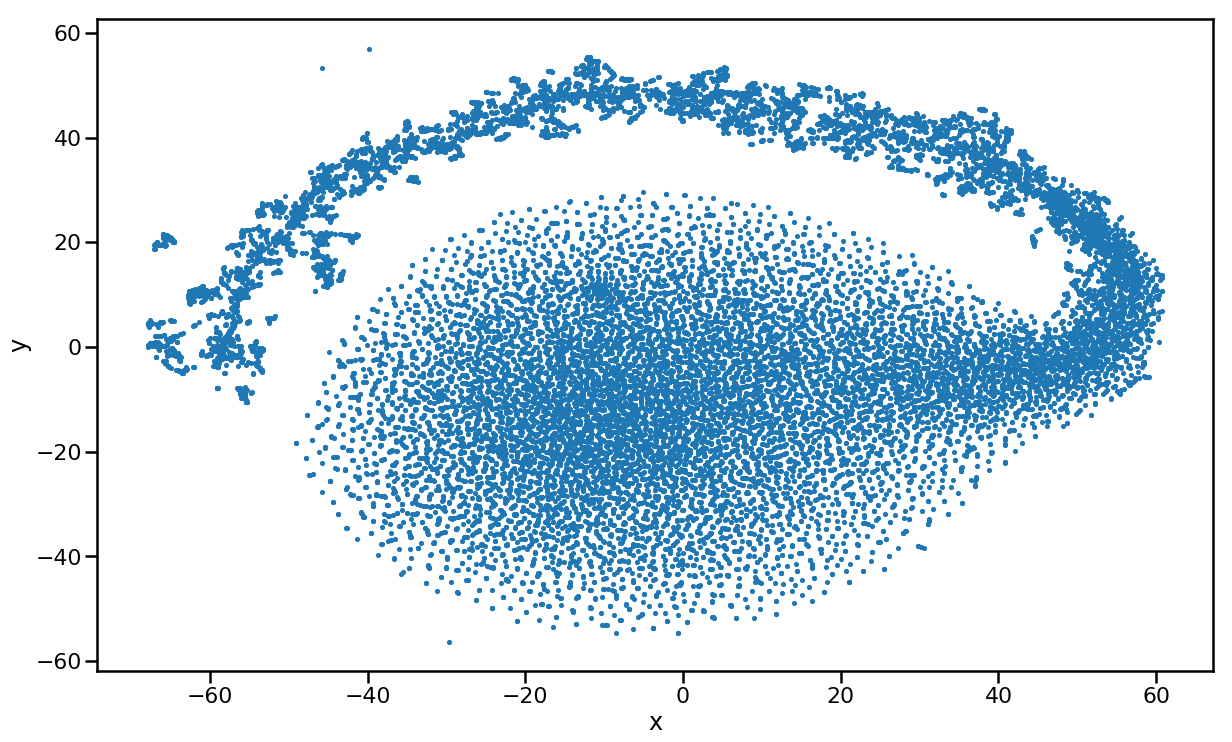

In [25]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [26]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

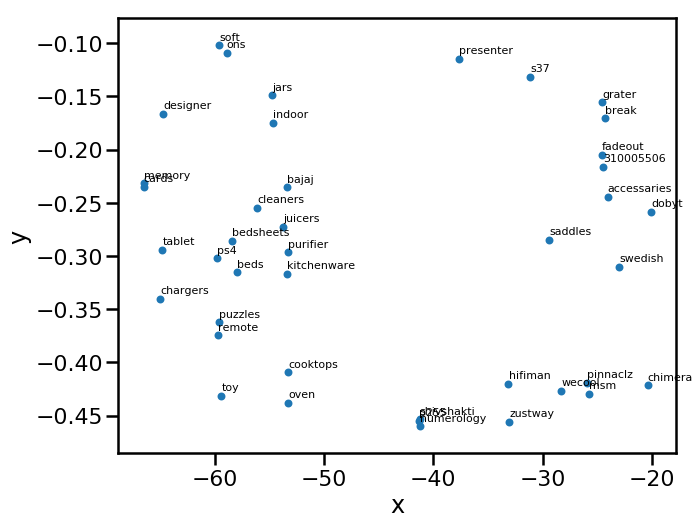

In [27]:
plot_region(x_bounds=(-400.0, -20), y_bounds=(-0.5, -0.1))

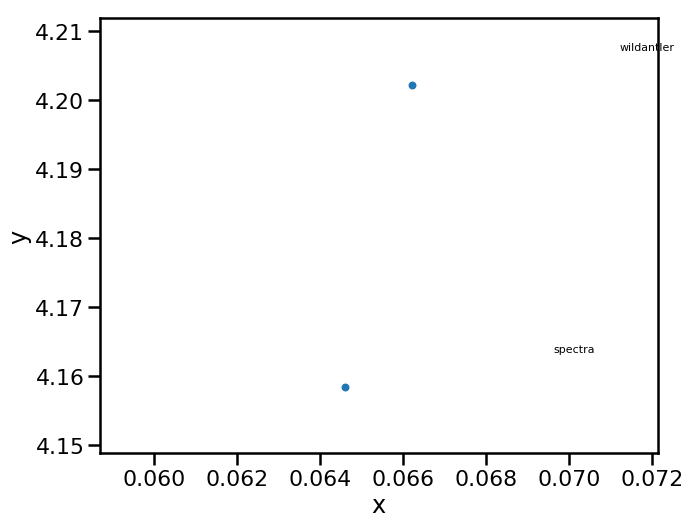

In [28]:
plot_region(x_bounds=(0, 0.2), y_bounds=(4, 4.5))

In [29]:
model.most_similar("clothing")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('wear', 0.9827161431312561),
 ('winter', 0.977878212928772),
 ('t', 0.9755977988243103),
 ('ethnic', 0.9732176065444946),
 ('western', 0.9726247787475586),
 ('seasonal', 0.9708606600761414),
 ('shirts', 0.9669156074523926),
 ('polos', 0.96522057056427),
 ('sarees', 0.9609901905059814),
 ('tops', 0.9609730243682861)]

In [30]:
model.most_similar("mobile")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('mi', 0.9734029769897461),
 ('apple', 0.9686694145202637),
 ('motorola', 0.9456390738487244),
 ('mobiles', 0.9447419047355652),
 ('screen', 0.934180498123169),
 ('cables', 0.9325572848320007),
 ('wired', 0.9227458834648132),
 ('tablets', 0.9209083318710327),
 ('electronics', 0.9176106452941895),
 ('smartphones', 0.9173860549926758)]

In [31]:
model.most_similar('furniture')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('room', 0.9774188995361328),
 ('dining', 0.9759263396263123),
 ('heating', 0.9673441052436829),
 ('cooling', 0.9631428718566895),
 ('living', 0.9621728658676147),
 ('containers', 0.9582493305206299),
 ('geysers', 0.9571182727813721),
 ('heaters', 0.951845645904541),
 ('bottles', 0.9494253396987915),
 ('fans', 0.9492974281311035)]

In [32]:
print(model)

Word2Vec(vocab=19930, size=300, alpha=0.025)


In [45]:
# similar_to_cloth = []
# tmp_list = model.most_similar('clothing')
# for data in tmp_list :
#     similar_to_cloth.append(data[0])
# similar_to_cloth.append('clothing')
# similar_to_cloth.remove('t')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


In [47]:
# similar_to_cloth

['wear',
 'winter',
 'ethnic',
 'western',
 'seasonal',
 'shirts',
 'polos',
 'sarees',
 'tops',
 'clothing']

In [48]:
for row in range(len(df)) :
    cnt = False
    
    for data in similar_to_cloth :
            if data in str(df['breads'][row]) :
                cnt = True
            
    if cnt == False :
        df['label'][row] = 'not clothing'
    else :
        df['label'][row] = 'clothing'

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [52]:
df.head()

,breads,label
0,clothing accessories men winterwear jackets,1
1,clothing accessories men winterwear sweatshirt...,1
2,shoes handbags shoes men s shoes men running s...,0
3,home entertainment audio video tv headphones e...,0
4,home kitchen small kitchen appliances mixer gr...,0


In [53]:
# len(df)

In [177]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm

#  Vectorizing our dataset
df.loc[df['label'] == 'clothing', 'label'] = 1
df.loc[df['label'] == 'not clothing', 'label'] = 0

df_x = df.breads
df_y = df.label

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state = 1)

cv = CountVectorizer()
x_train_dtm = cv.fit_transform(x_train)
x_test_dtm = cv.transform(x_test)
X = np.array(x_train_dtm)
Y = np.array(y_train)

# # Building and evaluating a model

clf = svm.SVC()
clf.fit(X, Y)
# # accuracy = clf.score(bdc_train, y_train)
# # # predict = clf.predict(bdc_test)
# # print(accuracy)

ValueError: setting an array element with a sequence.